<h1 style="text-align: center;">DQN EPISODE (INITIAL DATA)</h1>

## 0. PACKAGE REQUIREMENTS

In [1]:
# Packages
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from IPython import display
from IPython.display import clear_output
from ipywidgets import Output
import warnings

# DQN Requirements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple

# Model imports
import sys
import os

/Users/emilialautz/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
warnings.filterwarnings("ignore", message=".*To copy construct from a tensor.*")

In [3]:
# Environment requirements
module_path = os.path.abspath(os.path.join('..', '..', 'environment'))
if module_path not in sys.path:
    sys.path.append(module_path)
from environment import Job, Candidate, Environment

module_path = os.path.abspath(os.path.join('..', '..', 'environment'))
if module_path not in sys.path:
    sys.path.append(module_path)
from environment_debias import EnvironmentDebiased

# Agent requirements
module_path = os.path.abspath(os.path.join('..', '..', 'agents'))
if module_path not in sys.path:
    sys.path.append(module_path)
from agents import DQNAgent, DQN, ReplayBuffer

# Tool requirements
module_path = os.path.abspath(os.path.join('..', '..', 'tools'))
if module_path not in sys.path:
    sys.path.append(module_path)
from tools import calculate_sampled_men, calculate_hired_men, get_best_allocation, visualize_loss, set_seed

## 1. DQN EPISODE FUNCTIONS

In [4]:
def run_dqn_agent(sample_jobs, sample_candidates, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, num_episodes, show_schedule = False):
    # Initialise the environment
    env = Environment(sample_jobs, sample_candidates)
    state = env.reset()
    state_tensor = torch.tensor(state.to_tensor(), dtype=torch.float32).unsqueeze(0)

    # Initialise the state and action sizes
    state_size = state.num_jobs * state.num_candidates 
    action_size = len(state.available_actions)

    episode_rewards = []
    loss_list = []
    iteration = 0

    # Initialise the agent
    agent = DQNAgent(state_size, action_size, env, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate)
    print(f"State size: {state_size}, Action size: {action_size}")

    for _ in range(num_episodes):
        iteration += 1
        state = env.reset()
        state_tensor = torch.tensor(state.to_tensor(), dtype=torch.float32).unsqueeze(0)
        total_reward = 0
        done = False

        while not done:
            action_tuple = agent.select_action(state_tensor, env.current_state.available_actions, env.action_indices)
            next_state, reward, done = env.step(action_tuple)
            next_state_tensor = torch.tensor(next_state.to_tensor(), dtype=torch.float32).unsqueeze(0)

            agent.store_transition(state_tensor, action_tuple, reward, next_state_tensor, done)
            state_tensor = next_state_tensor

            loss = agent.optimize_model()
            total_reward += reward

            if done:
                agent.update_target_net()
                episode_rewards.append(total_reward)
                break
        
        loss_list.append(loss)

        # Visualise the loss
        if iteration % 50 == 0:
            visualize_loss(loss_list)
            print(f"Episode {iteration}: Model loss = {loss}")
    
    # Save and load the model
    agent.save_model('DQN_optimisation')
    agent.load_model('DQN_optimisation')
        
    gender_distribution, tot_reward = get_best_allocation(agent, env, show_schedule=True)

    return gender_distribution, tot_reward, loss_list

In [12]:
def episode_dqn_agent(num_jobs, num_candidates, job_list, candidate_list, results_parameters_dqn, running_seed, num_episodes, results_df):
    # Initialise the data
    random.seed(1)
    sample_jobs = random.sample(job_list, num_jobs)
    random.seed(1)
    sample_candidates = random.sample(candidate_list, num_candidates)

    # Extract the optimised parameters
    parameters_df = results_parameters_dqn[(results_parameters_dqn['jobs'] == num_jobs) & (results_parameters_dqn['candidates'] == num_candidates)]
    best_row = results_parameters_dqn.iloc[parameters_df['total_reward'].idxmax()]

    batch_size = int(best_row['batch_size'])
    gamma = best_row['gamma']
    epsilon = best_row['epsilon']
    epsilon_min = best_row['epsilon_min']
    epsilon_decay = best_row['epsilon_decay']
    learning_rate = best_row['learning_rate']

    # Run the dqn agent
    set_seed(running_seed)
    gender_distribution, total_reward, loss_list = run_dqn_agent(sample_jobs, sample_candidates, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, num_episodes)

    # Evaluate the allocations
    sampled_men = calculate_sampled_men(sample_candidates)
    hired_men = calculate_hired_men(gender_distribution)

    men_count = gender_distribution['Man'][0]
    women_count = gender_distribution['Woman'][0]

    # Add the results to results_df
    new_row = pd.DataFrame([{"agent": "DQN", "running_seed": running_seed, "sample_seed": 1, "num_jobs": num_jobs, "num_candidates": num_candidates, "reward": total_reward,  
                             "sampled_men_percent": sampled_men, "hired_men_percent": hired_men, "hired_women_count": women_count, "hired_men_count": men_count,
                             "data": 'initial_data', "debiased": 'No'}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df, loss_list


In [13]:
def run_dqn_agent_debiased(sample_jobs, sample_candidates, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, num_episodes, show_schedule = False):
    # Initialise the environment
    env = EnvironmentDebiased(sample_jobs, sample_candidates)
    state = env.reset()
    state_tensor = torch.tensor(state.to_tensor(), dtype=torch.float32).unsqueeze(0)

    # Initialise the state and action sizes
    state_size = state.num_jobs * state.num_candidates 
    action_size = len(state.available_actions)

    episode_rewards = []
    loss_list = []
    iteration = 0

    # Initialise the agent
    agent = DQNAgent(state_size, action_size, env, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate)
    print(f"State size: {state_size}, Action size: {action_size}")

    for _ in range(num_episodes):
        iteration += 1
        state = env.reset()
        state_tensor = torch.tensor(state.to_tensor(), dtype=torch.float32).unsqueeze(0)
        total_reward = 0
        done = False

        while not done:
            action_tuple = agent.select_action(state_tensor, env.current_state.available_actions, env.action_indices)
            next_state, reward, done = env.step(action_tuple)
            next_state_tensor = torch.tensor(next_state.to_tensor(), dtype=torch.float32).unsqueeze(0)

            agent.store_transition(state_tensor, action_tuple, reward, next_state_tensor, done)
            state_tensor = next_state_tensor

            loss = agent.optimize_model()
            total_reward += reward

            if done:
                agent.update_target_net()
                episode_rewards.append(total_reward)
                break
        
        loss_list.append(loss)

        # Visualise the loss
        if iteration % 50 == 0:
            visualize_loss(loss_list)
            print(f"Episode {iteration}: Model loss = {loss}")
    
    # Save and load the model
    agent.save_model('DQN_optimisation')
    agent.load_model('DQN_optimisation')
        
    gender_distribution, tot_reward = get_best_allocation(agent, env, show_schedule=True)

    return gender_distribution, tot_reward, loss_list

In [14]:
def episode_dqn_agent_debiased(num_jobs, num_candidates, job_list, candidate_list, results_parameters_dqn, running_seed, num_episodes, results_df):
    # Initialise the data
    random.seed(1)
    sample_jobs = random.sample(job_list, num_jobs)
    random.seed(1)
    sample_candidates = random.sample(candidate_list, num_candidates)

    # Extract the optimised parameters
    parameters_df = results_parameters_dqn[(results_parameters_dqn['jobs'] == num_jobs) & (results_parameters_dqn['candidates'] == num_candidates)]
    best_row = results_parameters_dqn.iloc[parameters_df['total_reward'].idxmax()]

    batch_size = int(best_row['batch_size'])
    gamma = best_row['gamma']
    epsilon = best_row['epsilon']
    epsilon_min = best_row['epsilon_min']
    epsilon_decay = best_row['epsilon_decay']
    learning_rate = best_row['learning_rate']

    # Run the dqn agent
    set_seed(running_seed)
    gender_distribution, total_reward, loss_list = run_dqn_agent_debiased(sample_jobs, sample_candidates, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, num_episodes)

    # Evaluate the allocations
    sampled_men = calculate_sampled_men(sample_candidates)
    hired_men = calculate_hired_men(gender_distribution)

    men_count = gender_distribution['Man'][0]
    women_count = gender_distribution['Woman'][0]

    # Add the results to results_df
    new_row = pd.DataFrame([{"agent": "DQN", "running_seed": running_seed, "sample_seed": 1, "num_jobs": num_jobs, "num_candidates": num_candidates, "reward": total_reward,  
                             "sampled_men_percent": sampled_men, "hired_men_percent": hired_men, "hired_women_count": women_count, "hired_men_count": men_count,
                             "data": 'initial_data', "debiased": 'Yes'}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df, loss_list

## 2. INITIALISE THE DATA

In [15]:
# Read in the job data
file_path = '../../data/jobs_data_cleaned.csv'
jobs_df = pd.read_csv(file_path)

# Read in the candidate data
file_path = '../../data/candidates_data_cleaned.csv'
candidates_df = pd.read_csv(file_path)

# Initialise the class objects with data from the dataframes
job_list = []
for i in range(len(jobs_df)):
    job = Job(i+1, jobs_df['Degree_Bachelor'][i], jobs_df['Degree_Master'][i], jobs_df['Degree_Other'][i],
              jobs_df['Software_Programming'][i], jobs_df['C_Programming'][i], jobs_df['Python_Programming'][i], 
              jobs_df['JavaScript_Programming'][i], jobs_df['Professional_Software_Experience'][i], 
              jobs_df['Management_Skills'][i], jobs_df['Engineer'][i], int(jobs_df['Minimum_Pay'][i]))
    job_list.append(job)

candidate_list = []
for i in range(len(candidates_df)):
    candidate = Candidate(i+1, candidates_df['Gender'][i], candidates_df['Degree_Bachelor'][i], candidates_df['Degree_Master'][i], candidates_df['Degree_Other'][i], 
                          candidates_df['Software_Programming'][i], candidates_df['C_Programming'][i], candidates_df['Python_Programming'][i], 
                          candidates_df['JavaScript_Programming'][i], candidates_df['Professional_Software_Experience'][i], 
                          candidates_df['Management_Skills'][i], candidates_df['Engineer'][i], int(candidates_df['Previous_Pay'][i]))
    candidate_list.append(candidate)

print("Job Data:", len(job_list), " Candidate Data:", len(candidate_list))

Job Data: 806  Candidate Data: 49005


## 3. EPISODES (ORIGINAL)

In [17]:
# Read in the hyperparameter results
results_parameters_dqn = pd.read_csv('../../optimisation/optimisation_initial_data/results_parameters_dqn_initial.csv')

# Initialise a dataframe to store the results
columns = ["agent", "running_seed", "sample_seed", "num_jobs", "num_candidates", "reward", "sampled_men_percent", "hired_men_percent", "hired_women_count", "hired_men_count", "data", "debiased"]
dqn_results_df = pd.DataFrame(columns=columns)

In [18]:
dqn_results_df

,agent,running_seed,sample_seed,num_jobs,num_candidates,reward,sampled_men_percent,hired_men_percent,hired_women_count,hired_men_count,data,debiased


<Figure size 640x480 with 0 Axes>

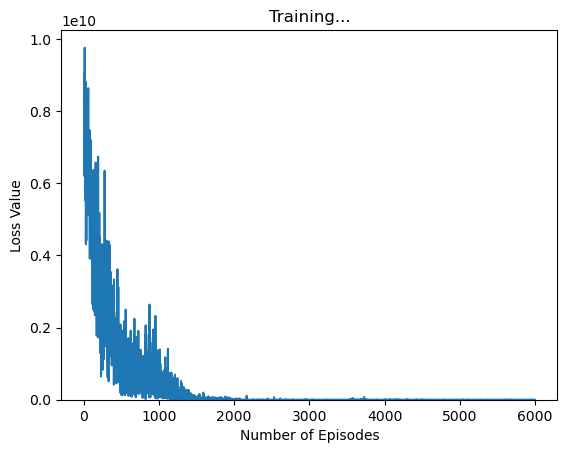

Episode 6000: Model loss = 5751.0751953125
Allocations:
Job 0 allocated to Candidate 12
Job 1 allocated to Candidate 81
Job 2 allocated to Candidate 86
Job 3 allocated to Candidate 95
Job 4 allocated to Candidate 25
Job 5 allocated to Candidate 13
Job 6 allocated to Candidate 24
Job 7 allocated to Candidate 52
Job 9 allocated to Candidate 56

Gender distribution:
   Woman  Man
0      1    8
None
Reward:  -204513


In [19]:
# 10 Jobs, 100 Candidates, running seed 1 (-204513)
dqn_results_df, loss_list_10 = episode_dqn_agent(10, 100, job_list, candidate_list, results_parameters_dqn, 1, 6000, dqn_results_df)

<Figure size 640x480 with 0 Axes>

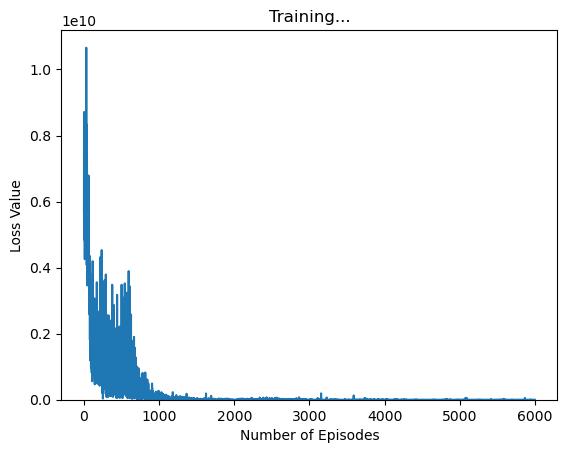

Episode 6000: Model loss = 10441.1611328125
Allocations:
Job 0 allocated to Candidate 89
Job 1 allocated to Candidate 0
Job 2 allocated to Candidate 49
Job 3 allocated to Candidate 56
Job 4 allocated to Candidate 73
Job 5 allocated to Candidate 31
Job 6 allocated to Candidate 24
Job 7 allocated to Candidate 12
Job 9 allocated to Candidate 78
Job 10 allocated to Candidate 68
Job 11 allocated to Candidate 25
Job 12 allocated to Candidate 95
Job 13 allocated to Candidate 13
Job 14 allocated to Candidate 81
Job 15 allocated to Candidate 16
Job 16 allocated to Candidate 90
Job 17 allocated to Candidate 65
Job 18 allocated to Candidate 86
Job 19 allocated to Candidate 71

Gender distribution:
   Woman  Man
0      2   17
None
Reward:  -651257


In [14]:
# 20 Jobs, 100 Candidates, running seed 1 (-651257)
dqn_results_df, loss_list_20 = episode_dqn_agent(20, 100, job_list, candidate_list, results_parameters_dqn, 1, 6000, dqn_results_df)

<Figure size 640x480 with 0 Axes>

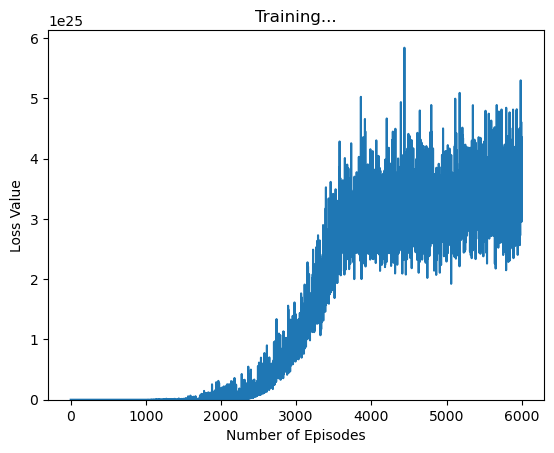

Episode 6000: Model loss = 3.555452200545686e+25
Allocations:
Job 0 allocated to Candidate 89
Job 2 allocated to Candidate 84
Job 3 allocated to Candidate 25
Job 4 allocated to Candidate 65
Job 5 allocated to Candidate 72
Job 6 allocated to Candidate 0
Job 7 allocated to Candidate 74
Job 9 allocated to Candidate 95
Job 10 allocated to Candidate 68
Job 11 allocated to Candidate 56
Job 12 allocated to Candidate 73
Job 13 allocated to Candidate 9
Job 14 allocated to Candidate 36
Job 16 allocated to Candidate 90
Job 17 allocated to Candidate 21
Job 18 allocated to Candidate 49
Job 19 allocated to Candidate 78
Job 20 allocated to Candidate 71
Job 21 allocated to Candidate 77
Job 22 allocated to Candidate 20
Job 23 allocated to Candidate 97
Job 24 allocated to Candidate 13
Job 25 allocated to Candidate 24
Job 27 allocated to Candidate 16
Job 28 allocated to Candidate 80
Job 30 allocated to Candidate 64
Job 32 allocated to Candidate 44
Job 33 allocated to Candidate 7
Job 34 allocated to Candi

In [17]:
# 50 Jobs, 100 Candidates, running seed 1 (-2099590)
dqn_results_df, loss_list_50 = episode_dqn_agent(50, 100, job_list, candidate_list, results_parameters_dqn, 1, 6000, dqn_results_df)

In [12]:
# 100 Jobs, 100 Candidates, running seed 1 (-3491106)
dqn_results_df, loss_list_100 = episode_dqn_agent(100, 100, job_list, candidate_list, results_parameters_dqn, 1, 6000, dqn_results_df)

ValueError: attempt to get argmax of an empty sequence

## 4. RESULTS (ORIGINAL)

In [18]:
dqn_results_df

,agent,running_seed,sample_seed,num_jobs,num_candidates,reward,sampled_men_percent,hired_men_percent,hired_women_count,hired_men_count,data,debiased
0,DQN,1,1,10,100,-204513,0.97,0.888889,1,8,initial_data,No
1,DQN,1,1,20,100,-651257,0.97,0.894737,2,17,initial_data,No
2,DQN,1,1,50,100,-2099590,0.97,0.925000,3,37,initial_data,No


In [19]:
# Save the dqn results to a csv file
dqn_results_df.to_csv("dqn_results_initial_data.csv")

## 5. LOSS (ORIGINAL)

In [20]:
# Store the loss_lists in a csv file to create graphs
#loss_list_df = pd.DataFrame({10: loss_list_10, 20: loss_list_20})
loss_list_df = pd.DataFrame({10: loss_list_10, 20: loss_list_20, 50: loss_list_50})
loss_list_df.to_csv("dqn_loss_initial_data.csv")

In [33]:
loss_list_df[:5]

,10,20,50
0,NaN,5.640964e+09,NaN
1,8.348786e+09,7.670248e+09,6.465258e+09
2,8.274940e+09,5.649636e+09,6.247072e+09
3,6.496948e+09,7.045774e+09,6.334169e+09
4,7.719167e+09,8.713556e+09,7.229299e+09


## 6. EPISODES (DEBIASED)

In [23]:
# Read in the hyperparameter results
results_parameters_dqn_debiased = pd.read_csv('../../optimisation/optimisation_debias/results_parameters_dqn_debiased.csv')
results_parameters_dqn_debiased = results_parameters_dqn_debiased[results_parameters_dqn_debiased['data'] == 'initial_data'].reset_index(drop=True)

# Initialise a dataframe to store the results
columns = ["agent", "running_seed", "sample_seed", "num_jobs", "num_candidates", "reward", "sampled_men_percent", "hired_men_percent", "hired_women_count", "hired_men_count", "data", "debiased"]
dqn_debiased_results_df = pd.DataFrame(columns=columns)

In [24]:
dqn_debiased_results_df

,agent,running_seed,sample_seed,num_jobs,num_candidates,reward,sampled_men_percent,hired_men_percent,hired_women_count,hired_men_count,data,debiased


<Figure size 640x480 with 0 Axes>

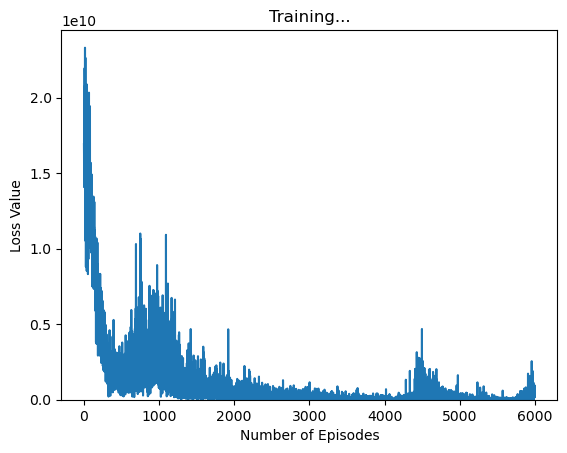

Episode 6000: Model loss = 496416672.0
Allocations:
Job 0 allocated to Candidate 12
Job 1 allocated to Candidate 81
Job 2 allocated to Candidate 86
Job 3 allocated to Candidate 13
Job 4 allocated to Candidate 95
Job 5 allocated to Candidate 56
Job 6 allocated to Candidate 24
Job 7 allocated to Candidate 44
Job 9 allocated to Candidate 31

Gender distribution:
   Woman  Man
0      2    7
None
Reward:  -261802.10000000003


In [25]:
# 10 Jobs, 100 Candidates, running seed 1 (-261802.10000000003)
dqn_debiased_results_df, loss_list_debiased_10 = episode_dqn_agent_debiased(10, 100, job_list, candidate_list, results_parameters_dqn_debiased, 1, 6000, dqn_debiased_results_df)

<Figure size 640x480 with 0 Axes>

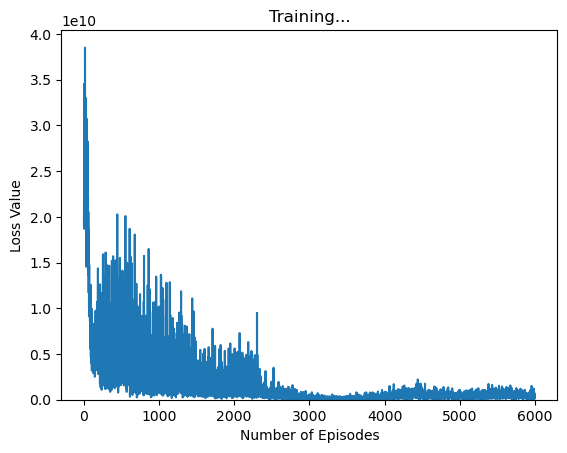

Episode 6000: Model loss = 545676288.0
Allocations:
Job 0 allocated to Candidate 89
Job 1 allocated to Candidate 12
Job 2 allocated to Candidate 86
Job 3 allocated to Candidate 25
Job 4 allocated to Candidate 31
Job 5 allocated to Candidate 56
Job 6 allocated to Candidate 81
Job 7 allocated to Candidate 24
Job 9 allocated to Candidate 64
Job 10 allocated to Candidate 68
Job 11 allocated to Candidate 73
Job 12 allocated to Candidate 65
Job 13 allocated to Candidate 95
Job 14 allocated to Candidate 0
Job 15 allocated to Candidate 16
Job 16 allocated to Candidate 90
Job 17 allocated to Candidate 13
Job 18 allocated to Candidate 49
Job 19 allocated to Candidate 71

Gender distribution:
   Woman  Man
0      3   16
None
Reward:  -1189910.6


In [27]:
# 20 Jobs, 100 Candidates, running seed 1 (-1189910.6)
dqn_debiased_results_df, loss_list_debiased_20 = episode_dqn_agent_debiased(20, 100, job_list, candidate_list, results_parameters_dqn_debiased, 1, 6000, dqn_debiased_results_df)

In [28]:
dqn_debiased_results_df

,agent,running_seed,sample_seed,num_jobs,num_candidates,reward,sampled_men_percent,hired_men_percent,hired_women_count,hired_men_count,data,debiased
0,DQN,1,1,10,100,-261802.1,0.97,0.777778,2,7,initial_data,Yes
1,DQN,1,1,20,100,-1189910.6,0.97,0.842105,3,16,initial_data,Yes


<Figure size 640x480 with 0 Axes>

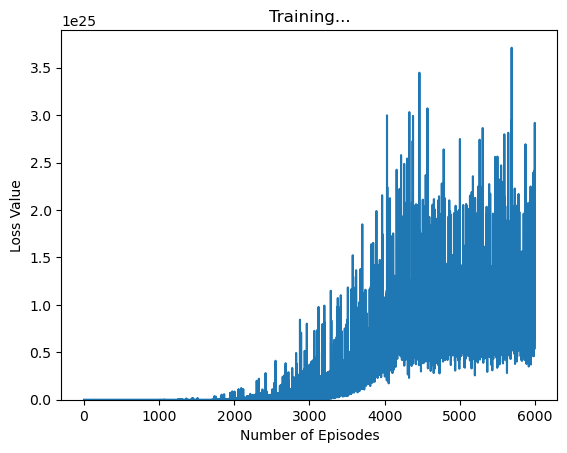

Episode 6000: Model loss = 5.425811739072724e+24
Allocations:
Job 0 allocated to Candidate 77
Job 2 allocated to Candidate 9
Job 3 allocated to Candidate 31
Job 4 allocated to Candidate 81
Job 5 allocated to Candidate 83
Job 6 allocated to Candidate 7
Job 7 allocated to Candidate 85
Job 9 allocated to Candidate 2
Job 10 allocated to Candidate 68
Job 11 allocated to Candidate 73
Job 12 allocated to Candidate 78
Job 13 allocated to Candidate 95
Job 16 allocated to Candidate 67
Job 17 allocated to Candidate 56
Job 18 allocated to Candidate 64
Job 19 allocated to Candidate 24
Job 20 allocated to Candidate 49
Job 21 allocated to Candidate 69
Job 22 allocated to Candidate 21
Job 23 allocated to Candidate 97
Job 24 allocated to Candidate 65
Job 25 allocated to Candidate 36
Job 27 allocated to Candidate 72
Job 28 allocated to Candidate 29
Job 30 allocated to Candidate 44
Job 32 allocated to Candidate 16
Job 33 allocated to Candidate 0
Job 34 allocated to Candidate 90
Job 35 allocated to Candid

In [29]:
# 50 Jobs, 100 Candidates, running seed 1 (-5475272.100000001)
dqn_debiased_results_df, loss_list_debiased_50 = episode_dqn_agent_debiased(50, 100, job_list, candidate_list, results_parameters_dqn_debiased, 1, 6000, dqn_debiased_results_df)

## 8. RESULTS (DEBIASED)

In [30]:
dqn_debiased_results_df

,agent,running_seed,sample_seed,num_jobs,num_candidates,reward,sampled_men_percent,hired_men_percent,hired_women_count,hired_men_count,data,debiased
0,DQN,1,1,10,100,-261802.1,0.97,0.777778,2,7,initial_data,Yes
1,DQN,1,1,20,100,-1189910.6,0.97,0.842105,3,16,initial_data,Yes
2,DQN,1,1,50,100,-5475272.1,0.97,0.923077,3,36,initial_data,Yes


In [31]:
# Save the dqn results to a csv file
dqn_debiased_results_df.to_csv("dqn_debiased_results_initial_data.csv")